In [1]:
import os
import warnings

import IPython.display
import librosa
import librosa.display
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_run = 1

In [2]:
warnings.filterwarnings('ignore')

# Paths for data
Crema = "D:\Projects\Python_Projects\ML\SpeechEmotionRecognition_Pytorch\datasets\Crema"

# Classify emotions from files name
crema_emotions = {
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fear',
    'DIS': 'disgust'}



In [3]:
processed_data = []

# Create data frame for Crema data
for file in os.listdir(Crema):
    file_path = os.path.join(Crema, file)
    emotion = crema_emotions[file.split('_')[2]]
    processed_data.append([file_path, emotion])

audio_df = pd.DataFrame(processed_data, columns=['Filepath', 'Emotion'])


In [4]:
audio_arrays = []

for i in audio_df['Filepath']:
    # audio sr = 16000
    x, sr = librosa.load(i, sr=None, offset=0.6, duration=2.5)
    audio_arrays.append(x)

audio_df['Arrays'] = audio_arrays
audio_df

,Filepath,Emotion,Arrays
0,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,angry,"[0.01675415, 0.019073486, 0.022399902, 0.02642..."
1,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,disgust,"[0.03591919, 0.008361816, -0.014556885, -0.032..."
2,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,fear,"[-0.08529663, -0.043548584, -0.022064209, -0.0..."
3,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,happy,"[-0.020080566, -0.014465332, -0.010467529, -0...."
4,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,neutral,"[0.0101623535, 0.008087158, 0.00018310547, 0.0..."
...,...,...,...
7437,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,disgust,"[0.0046081543, 0.007659912, 0.006713867, 0.007..."
7438,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,fear,"[-0.0017089844, -0.0021362305, -0.0017700195, ..."
7439,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,happy,"[-0.0051879883, -0.004760742, -0.004699707, -0..."
7440,D:\Projects\Python_Projects\ML\SpeechEmotionRe...,neutral,"[0.03970337, 0.036010742, 0.032318115, 0.03414..."


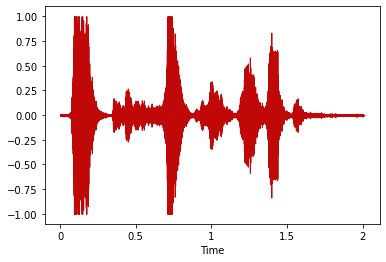

In [5]:
angfile = audio_df[audio_df['Emotion'] == 'angry']['Filepath']
angarray = audio_df[audio_df['Emotion'] == 'angry']['Arrays']

librosa.display.waveshow(angarray.iloc[1100], color='#C00808')
IPython.display.Audio(angfile.iloc[1100])

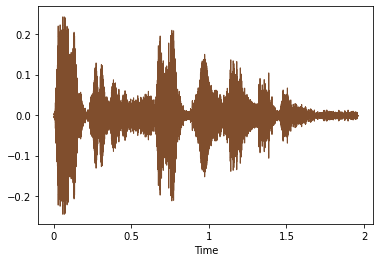

In [6]:
disfile = audio_df[audio_df['Emotion'] == 'disgust']['Filepath']
disarray = audio_df[audio_df['Emotion'] == 'disgust']['Arrays']

librosa.display.waveshow(disarray.iloc[1100], color='#804E2D')
IPython.display.Audio(disfile.iloc[1100])

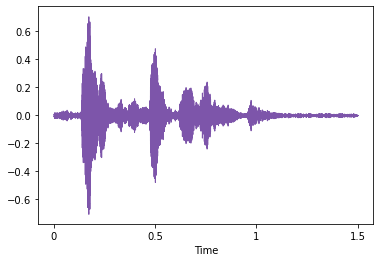

In [7]:
feafile = audio_df[audio_df['Emotion'] == 'fear']['Filepath']
feaarray = audio_df[audio_df['Emotion'] == 'fear']['Arrays']

librosa.display.waveshow(feaarray.iloc[1100], color='#7D55AA')
IPython.display.Audio(feafile.iloc[1100])

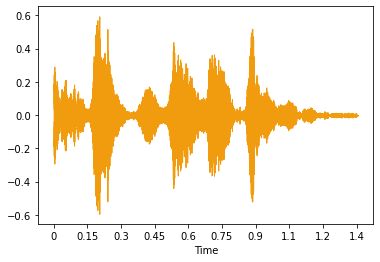

In [8]:
hapfile = audio_df[audio_df['Emotion'] == 'happy']['Filepath']
haparray = audio_df[audio_df['Emotion'] == 'happy']['Arrays']

librosa.display.waveshow(haparray.iloc[1100], color='#F19C0E')
IPython.display.Audio(hapfile.iloc[1100])

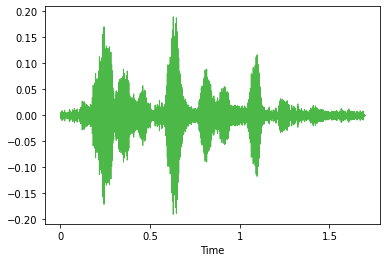

In [9]:
neufile = audio_df[audio_df['Emotion'] == 'neutral']['Filepath']
neuarray = audio_df[audio_df['Emotion'] == 'neutral']['Arrays']

librosa.display.waveshow(neuarray.iloc[1000], color='#4CB847')
IPython.display.Audio(neufile.iloc[1000])

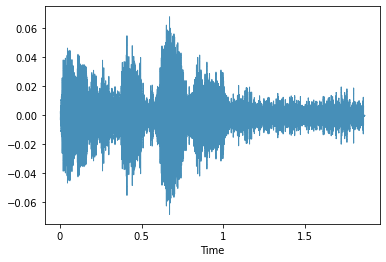

In [10]:
sadfile = audio_df[audio_df['Emotion'] == 'sad']['Filepath']
sadarray = audio_df[audio_df['Emotion'] == 'sad']['Arrays']

librosa.display.waveshow(sadarray.iloc[1100], color='#478FB8')
IPython.display.Audio(sadfile.iloc[1100])

In [11]:
def extract_features(data):
    mel = librosa.feature.melspectrogram(data, sr=16000)
    result = np.array(mel)

    padding = 128 - result.shape[1]
    if padding > 0:
        result = np.pad(result, [(0, 0), (0, abs(padding))], 'mean')
    elif padding != 0:
        result = result[:, :padding]
    return result


In [12]:
x = []
y = []

for i in range(len(audio_df)):
    feature = extract_features(audio_df['Arrays'].iloc[i])
    x.append(feature)
    y.append(audio_df['Emotion'].iloc[i])


In [13]:
x = np.array(x)

le = LabelEncoder()
y = le.fit_transform(y)

y = np.array(y)

In [14]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.05, stratify=y_train_val)

In [16]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape, y_test.shape

((4948, 128, 128), (261, 128, 128), (4948,), (261,), (2233, 128, 128), (2233,))

In [17]:
class MyDataset(Dataset):
    def __init__(self, array, label):
        self.array = array
        self.label = label

    def __getitem__(self, index):
        d = self.array[index].reshape((1, 128, 128))
        return torch.tensor(d, dtype=torch.float32, device=device), torch.tensor(self.label[index],
                                                                                 device=device)  #,device=device

    def __len__(self):
        return len(self.array)  # of how many examples(images?) you have

In [18]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=64, shuffle=True)  # ,num_workers=1,pin_memory=True


In [19]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=64, shuffle=True)

In [20]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=64, shuffle=True)

In [33]:
class Model_2D(nn.Module):
    def __init__(self):
        super(Model_2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=3,
                               stride=1)  # output size : (width - filter + 2*padding)/stride +1
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(8320, 256)  # dim c * w* h
        self.fc2 = nn.Linear(256, 6)

    def forward(self, data):
        #print(data.shape)
        data = self.conv1(data)
        #print(data.shape)
        data = F.relu(data)
        data = F.max_pool2d(data, kernel_size=3, stride=2)
        #print(data.shape)

        data = self.conv2(data)
        #print(data.shape)
        data = F.relu(data)
        data = F.max_pool2d(data, kernel_size=3, stride=2)
        #print(data.shape)

        data = self.conv3(data)
        data = F.relu(data)
        data = F.max_pool2d(data, kernel_size=3, stride=2)
        #print(data.shape)

        data = self.dropout1(data)
        data = torch.flatten(data, 1)

        data = self.fc1(data)
        data = F.relu(data)
        data = self.dropout2(data)

        data = self.fc2(data)

        #output = F.log_softmax(data, dim=1)

        return data

In [34]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # forward pass
        output = model(data)

        _, predicted = torch.max(output.data, 1)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # backward propagation dl/dw -> gradients
        loss_.backward()

        # update weights
        optimizer.step()

        pred += predicted.tolist()
        labels += label.tolist()

    return accuracy_score(labels, pred) * 100, total_loss / len(dataloader)


In [35]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            _, predicted = torch.max(output.data, 1)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()

            pred += predicted.tolist()
            labels += label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100, total_loss / len(dataloader)


In [36]:
# Function to save the model
def saveModel(model, model_path):
    torch.save(model.state_dict(), model_path)

In [37]:
model_path = "D:\Projects\Python_Projects\ML\SpeechEmotionRecognition_Pytorch\model_2D.pth"

if not first_run:
    torch.cuda.empty_cache()
    del x_train, x_val, y_train, y_val, x_test, y_test
first_run = 0

model = Model_2D().cuda()
#model.load_state_dict(torch.load(model_path))

epoch = 20

# about 5000 sample and batch size = 16 then 5000/16 ~= 300 iteration per epoch

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005 ,weight_decay=0.0001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold=0.0001)

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [38]:

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_loss)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, 'Training loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])


torch.Size([16, 1, 128, 128])
torch.Size([16, 256, 62, 62])
torch.Size([16, 256, 62, 62])
torch.Size([16, 256, 30, 30])
torch.Size([16, 256, 26, 26])
torch.Size([16, 256, 26, 26])
torch.Size([16, 256, 12, 12])
torch.Size([16, 128, 10, 10])
torch.Size([16, 128, 8, 8])
torch.Size([16, 96, 6, 6])
torch.Size([16, 96, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x96 and 8320x4096)

In [ ]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')
print('\n', classification_report(test_labels, test_pred))
print('\n', confusion_matrix(test_labels, test_pred))


In [ ]:
saveModel(model, model_path)

In [ ]:
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses')

plt.show()